## Information diffusion in a network using Linear Threshold model


PART 1 Implement LTM Model

In [73]:
# Importing required libraries
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import sklearn.metrics 
import numpy as np
import sys
import math
import json
import os

from random import random
from random import sample
from random import choice
from random import randint
from matplotlib import cm
from scipy import interp
import itertools
import time

In [74]:
def load_graph(graph_path):
    """
    Reading a NetworkX graph.
    :param graph_path: Path to the edge list.
    :return graph: NetworkX object.
    """
    data = pd.read_csv(graph_path)
    edges = data.values.tolist()
    edges = [[int(edge[0]), int(edge[1])] for edge in edges]
    graph = nx.from_edgelist(edges)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph

## read_csv_data of lastfm dataset ## pass relative path for dataset dir and csv
def read_csv_and_load_graph(relative_graph_dataset_path,csv_file_name):
    #dataset_path = os.getcwd() + "/lasftm_asia/"
    #edgelist_path = dataset_path + "lastfm_asia_edges.csv"
    dataset_path = os.getcwd() + relative_graph_dataset_path
    edgelist_path = dataset_path + csv_file_name
    graph = load_graph(edgelist_path)
    print("Number of nodes: ", graph.number_of_nodes())
    print("Number of edges: ", graph.number_of_edges())
    return graph
## get influential nodes 
def getInfluentialNodeList(influentialNodeparam,graph,numberOfNodes):
    if influentialNodeparam=="degree":
       return getInfluentialNodeDegree(graph,numberOfNodes)
    elif influentialNodeparam=="closeness":
       return getInfluentialNodeCloseness(graph,numberOfNodes)
    else:
      return None
    

def getInfluentialNodeDegree(graph,numberOfNodes):
  print("Evaluating most influential "+str(numberOfNodes)+" degree nodes")
  starttime = int(round(time.time() * 1000))
  nodes_degree_desc = sorted(graph.degree, key=lambda x: x[1], reverse=True)
  topten_degree_tuples = nodes_degree_desc[:numberOfNodes]
  topten_degree_nodes = [x[0] for x in topten_degree_tuples]
  endtime=int(round(time.time() * 1000))
  print("Time taken in getting most influential "+str(numberOfNodes)+" degree nodes "+str(endtime-starttime)+" ms")
 
  return topten_degree_nodes

def getInfluentialNodeCloseness(graph,numberOfNodes):
  print("Evaluating most influential "+str(numberOfNodes)+" closeness centrality nodes")
  starttime = int(round(time.time() * 1000))
  c=nx.closeness_centrality(graph)
  nodes_cc_recs = sorted(c.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
  topten_cc_recs = nodes_cc_recs[:numberOfNodes]
  topten_cc_nodes = [x[0] for x in topten_cc_recs]
  endtime=int(round(time.time() * 1000))
  print("Time taken in getting most influential "+str(numberOfNodes)+" closeness centrality nodes "+str(endtime-starttime)+" ms")
  return topten_cc_nodes


In [75]:
def LTMModel(graph,time_limit,compareList:list(),nodelist,activationData:list()):
    
    converted_list =nodelist
    threshold = {}
    count=0
    if converted_list is None:
      print("Please pass valid influential Node Parameter")
      print("Exiting !!!!")
      return -1
    for node in graph.nodes():
        threshold[node] = random()
    for t in range(time_limit):
        
        converted_list1 = converted_list
        for node in graph.nodes():
            total_weight = 0
            if graph.degree()[node]:
                weight = 1/float(graph.degree()[node])
            else:
                continue
            if graph.neighbors(node) is not  None:
                
                for each in graph.neighbors(node):
                    
                    if each is not None and each in converted_list:
                        total_weight = total_weight + weight
                    if total_weight > threshold[node]:
                       
                        if node not in converted_list:
                            count=count+1
                            converted_list.append(node)
                            #print(str(len(converted_list)) )
        if set(converted_list1) == set(converted_list):
          break

                    
    listcount=[]
    listcount.append(t)
    listcount.append(count)
    activationData.append(listcount)
            #print("Added to Iteration List "+str(t))
    in_first = set(converted_list)
    in_second = set(compareList)

    in_first_but_not_in_second = in_first - in_second
        #print(str(in_first_but_not_in_second))
    compareList.extend(list(in_first_but_not_in_second))
            #print("returing activated list "+str(len(compareList)))

    
    
    return compareList,activationData #This returns all the nodes in the network 

PART 2 SIMULATE LTM MODEL 

In [76]:
def printTimedData(activationData):
    df = pd.DataFrame(activationData, columns=['timeInterval(Itr)', 'Count'])
    df.plot.line()


def simulateLTMModel(graph,time_limit,InfluentialNodeparam,noOfInfluentialNodes):
    activated_node_list = []
    starttime = int(round(time.time() * 1000))
    totalIterations=0
    initList=getInfluentialNodeList(InfluentialNodeparam,graph,noOfInfluentialNodes)
    nodelist=[]
    activationData=[]
    check=True
    retry=int(0.0005*len(list(graph.nodes)) )
    prevlength=0
    '''this variable here prevents infinite 
    loop in case some of the nodes are completely disconnected from a network, 
    it tries for a fixed no of times and then breaks of the loop'''
    while(check):
      nodelist,activationData=LTMModel(graph,time_limit,nodelist,initList,activationData)
      in_first = set(nodelist)
      in_second = set(activated_node_list)
      in_first_but_not_in_second = in_first - in_second
      activated_node_list.extend(list(in_first_but_not_in_second))
      totalIterations+=1
      if len(activated_node_list)==prevlength:
         retry-=1
         if retry==0:
           print("There are some disconnected components !! Exiting the simulation and printing disconnected nodes ")
           graph_node_list=list(graph.nodes)
           disconnected_node_set=set(graph_node_list)-set(activated_node_list)
           print(str(list(disconnected_node_set)))
      prevlength=len(activated_node_list)
      if len(activated_node_list)==len(list(graph.nodes)) or retry==0:
        check=False
      print("Length of compareList->"+str(len(activated_node_list))+" in TotalIterations->"+str(totalIterations))
    
    printTimedData(activationData)
    endtime = int(round(time.time() * 1000))
    print("LTM information diffusion model execution took "+str(endtime-starttime)+" ms")
 



    
 

Load graph from dataset and simulation by degree based selection of influential nodes 

Number of nodes:  7624
Number of edges:  27806
Evaluating most influential 10 degree nodes
Time taken in getting most influential 10 degree nodes 7 ms
Length of compareList->384 in TotalIterations->1
Length of compareList->819 in TotalIterations->2
Length of compareList->1412 in TotalIterations->3
Length of compareList->2382 in TotalIterations->4
Length of compareList->3638 in TotalIterations->5
Length of compareList->4992 in TotalIterations->6
Length of compareList->6000 in TotalIterations->7
Length of compareList->6604 in TotalIterations->8
Length of compareList->7015 in TotalIterations->9
Length of compareList->7286 in TotalIterations->10
Length of compareList->7467 in TotalIterations->11
Length of compareList->7554 in TotalIterations->12
Length of compareList->7597 in TotalIterations->13
Length of compareList->7604 in TotalIterations->14
Length of compareList->7608 in TotalIterations->15
Length of compareList->7610 in TotalIterations->16
Length of compareList->7610 in TotalIteratio

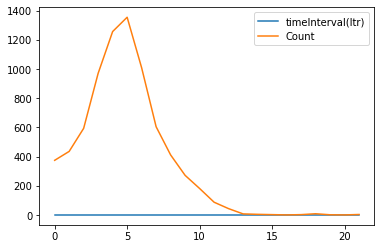

In [77]:
graph=read_csv_and_load_graph("/lasftm_asia/","lastfm_asia_edges.csv")
simulateLTMModel(graph,100,"degree",10)



Load graph and closeness based selection of influential nodes 

Evaluating most influential 10 closeness centrality nodes
Time taken in getting most influential 10 closeness centrality nodes 122029 ms
Length of compareList->298 in TotalIterations->1
Length of compareList->741 in TotalIterations->2
Length of compareList->1342 in TotalIterations->3
Length of compareList->2302 in TotalIterations->4
Length of compareList->3452 in TotalIterations->5
Length of compareList->4718 in TotalIterations->6
Length of compareList->5925 in TotalIterations->7
Length of compareList->6678 in TotalIterations->8
Length of compareList->7170 in TotalIterations->9
Length of compareList->7414 in TotalIterations->10
Length of compareList->7512 in TotalIterations->11
Length of compareList->7552 in TotalIterations->12
Length of compareList->7576 in TotalIterations->13
Length of compareList->7588 in TotalIterations->14
Length of compareList->7604 in TotalIterations->15
Length of compareList->7616 in TotalIterations->16
Length of compareList->7619 in TotalIterations->17
Length 

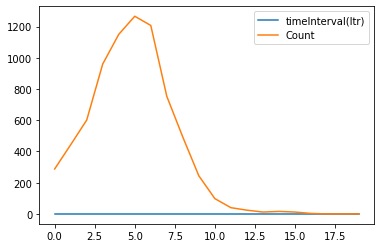

In [78]:
simulateLTMModel(graph,100,"closeness",10)

Changing hyperparameter i.e count of influential nodes in both degree and closeness based criteria

Evaluating most influential 20 degree nodes
Time taken in getting most influential 20 degree nodes 11 ms
Length of compareList->642 in TotalIterations->1
Length of compareList->1397 in TotalIterations->2
Length of compareList->2508 in TotalIterations->3
Length of compareList->3789 in TotalIterations->4
Length of compareList->4966 in TotalIterations->5
Length of compareList->5788 in TotalIterations->6
Length of compareList->6416 in TotalIterations->7
Length of compareList->6800 in TotalIterations->8
Length of compareList->7137 in TotalIterations->9
Length of compareList->7337 in TotalIterations->10
Length of compareList->7483 in TotalIterations->11
Length of compareList->7548 in TotalIterations->12
Length of compareList->7575 in TotalIterations->13
Length of compareList->7600 in TotalIterations->14
Length of compareList->7615 in TotalIterations->15
Length of compareList->7620 in TotalIterations->16
Length of compareList->7621 in TotalIterations->17
Length of compareList->7621 in TotalIt

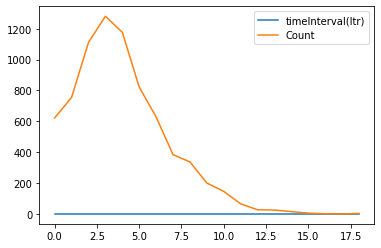

In [79]:
simulateLTMModel(graph,100,"degree",20)

Evaluating most influential 20closeness centrality nodes
Time taken in getting most influential 20closeness centrality nodes 130328 ms
Length of compareList->488 in TotalIterations->1
Length of compareList->1186 in TotalIterations->2
Length of compareList->2249 in TotalIterations->3
Length of compareList->3507 in TotalIterations->4
Length of compareList->4784 in TotalIterations->5
Length of compareList->5905 in TotalIterations->6
Length of compareList->6666 in TotalIterations->7
Length of compareList->7152 in TotalIterations->8
Length of compareList->7420 in TotalIterations->9
Length of compareList->7523 in TotalIterations->10
Length of compareList->7565 in TotalIterations->11
Length of compareList->7597 in TotalIterations->12
Length of compareList->7604 in TotalIterations->13
Length of compareList->7613 in TotalIterations->14
Length of compareList->7617 in TotalIterations->15
Length of compareList->7621 in TotalIterations->16
Length of compareList->7621 in TotalIterations->17
Length o

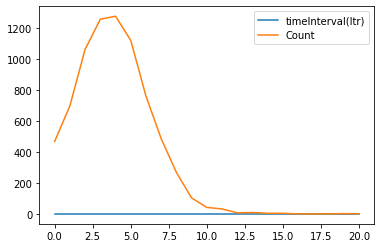

In [69]:
simulateLTMModel(graph,100,"closeness",20)